In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import time
import joblib
import pathlib
from scipy import stats
from sklearn import ensemble, metrics, inspection

In [2]:
## If true, load existing model (does not train a new one)
load_existing = False

## If true, save the trained model
save_model = True

## If true, evaluate and save feature importances
## Otherwise, load previous results
compute_importances = True

## Proton and pion momenta
## 'VF': use VF momenta
## 'DTF': use DTF momenta w/o Lambda m.c.
## 'DTFL': use DTF momenta w/ Lambda m.c.
## 'NO': don't use any momenta for Lambda daughter particles
daughterMomenta = 'NO'

In [3]:
parameters = {
    'random_state': 2021,
    'learning_rate': 0.1,
    'max_depth': 4,
    'max_features': 3,
    'n_estimators': 200,
    'subsample': 0.7
}

In [4]:
fileNamePattern = (
    'BDT_'
    + daughterMomenta
    + '_' + str(parameters['learning_rate'])
    + '_' + str(parameters['max_depth'])
    + '_' + str(parameters['max_features'])
    + '_' + str(parameters['n_estimators'])
    + '_' + str(parameters['subsample'])
)

fileNamePattern

'BDT_NO_0.1_4_3_200_0.7'

In [5]:
## Create save state directory, if missing
savedStateDirectory = './saved_states'
pathlib.Path(savedStateDirectory).mkdir(parents=True, exist_ok=True)

## Create plots directory, if missing
plotsDirectory = '/home/adegenna/2sb-classifier-studies/plots/BDT/' + fileNamePattern
pathlib.Path(plotsDirectory).mkdir(parents=True, exist_ok=True)

# Load data

In [6]:
inputTrain = '~/classifier-studies/data/trainData.h5'
df_train = pd.read_hdf(inputTrain, 'LHCb_Train')
df_train

,p_PT,p_PZ,DTF_FixJPsi_p_PT,DTF_FixJPsi_p_PZ,DTF_FixJPsiLambda_p_PT,DTF_FixJPsiLambda_p_PZ,pim_PT,pim_PZ,DTF_FixJPsi_pim_PT,DTF_FixJPsi_pim_PZ,...,L_VFASPF_CHI2_VDOF,Lb_VFASPF_CHI2_VDOF,L_BPVIPCHI2,Lb_BPVIPCHI2,L_BPVVDCHI2,Lb_BPVVDCHI2,DTF_FixJPsi_status,DTF_FixJPsiLambda_status,TYPE,DTF_FixJPsiLambda_Lb_M
0,1499.261230,64090.687500,1449.125122,71109.312500,1339.061157,67585.578125,142.576462,16002.674805,222.223770,15295.935547,...,12.397956,1.006837,3.118125,4.247471,8394.141602,839.898499,0.0,0.0,1,5649.782715
1,6531.696777,43770.664062,7950.545410,53713.472656,7250.666016,48946.476562,1098.382568,7154.821289,1173.632935,7339.285645,...,72.018669,4.932845,9.285525,0.700478,316576.343750,28.328979,0.0,0.0,1,5346.287598
2,1195.592285,25513.001953,2846.242432,45061.835938,2590.605225,40850.550781,600.855042,6536.190430,531.966919,6502.588379,...,58.929020,38.498478,109.721619,0.822907,48769.886719,969.064880,0.0,0.0,1,5625.960449
3,8357.870117,48524.460938,13019.551758,77204.125000,10886.081055,65169.863281,954.039429,8363.340820,1251.309082,8721.902344,...,4.634126,2.500692,5.822659,0.760508,2613.000244,11152.960938,0.0,0.0,1,5480.049316
4,931.300659,24994.496094,1355.522217,32809.832031,1152.498901,30213.080078,812.275085,7415.243652,194.003128,7669.465332,...,2.344827,9.562636,28.231209,3.574740,1273.676514,22431.037109,0.0,1.0,1,5446.454102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228493,1220.226567,72937.663691,1427.535278,85209.820312,1239.802612,67344.187500,1089.563873,38845.872752,961.556641,37909.199219,...,0.152025,0.212239,0.582464,8.037920,2371.744690,126.815938,0.0,1.0,0,6832.868652
228494,1083.955904,55949.470793,1105.869141,60395.519531,892.092041,48183.257812,450.382581,27721.281600,485.050476,26523.736328,...,0.300803,1.908871,0.620846,1.462356,74049.033084,19.377282,0.0,1.0,0,6612.175781
228495,567.501520,37682.446927,5925.211914,436724.312500,1658.590454,121800.218750,398.880250,12929.648726,275.511749,10452.941406,...,257.919474,67.560202,197.839502,175.666290,368006.797335,212.409329,0.0,1.0,0,8911.302734
228496,758.780272,33543.168911,941.613098,42739.785156,7304.916016,323111.187500,705.825113,29903.281153,768.507690,34001.078125,...,0.161039,2.624455,7.957362,99.010018,4205.262286,418.366858,0.0,1.0,0,9774.763672


In [7]:
inputTest = '~/classifier-studies/data/testData.h5'
df_test = pd.read_hdf(inputTest, 'LHCb_Test')
df_test

,p_PT,p_PZ,DTF_FixJPsi_p_PT,DTF_FixJPsi_p_PZ,DTF_FixJPsiLambda_p_PT,DTF_FixJPsiLambda_p_PZ,pim_PT,pim_PZ,DTF_FixJPsi_pim_PT,DTF_FixJPsi_pim_PZ,...,L_VFASPF_CHI2_VDOF,Lb_VFASPF_CHI2_VDOF,L_BPVIPCHI2,Lb_BPVIPCHI2,L_BPVVDCHI2,Lb_BPVVDCHI2,DTF_FixJPsi_status,DTF_FixJPsiLambda_status,TYPE,DTF_FixJPsiLambda_Lb_M
0,2504.376465,27455.556641,2435.769775,27417.642578,2798.346191,31182.896484,416.471710,5826.424316,492.247925,5925.514648,...,0.116805,0.334404,0.975463,2.368801,8.063968e+03,1031.350098,0.0,0.0,1,5678.738770
1,3678.204834,28957.984375,8009.698242,63035.414062,4010.383301,31700.259766,511.451996,4495.157227,606.036377,5295.169922,...,129.013321,2.213622,3.035450,4.987368,1.139099e+06,132.812775,0.0,0.0,1,5152.405273
2,6151.153320,62528.351562,3390.550049,34433.933594,3191.249023,32347.107422,908.855103,8341.050781,954.033325,8586.155273,...,3.052457,1.626008,3.995702,3.794894,5.994128e+05,1733.996338,0.0,0.0,1,5610.329102
3,2215.048828,16164.611328,3509.922363,25586.275391,3299.109375,24183.917969,1217.576172,8981.918945,1129.961060,8099.306641,...,3.684547,6.168911,7.633062,1.222096,6.435177e+03,1848.107422,0.0,0.0,1,5655.911133
4,1299.116333,50831.921875,1585.503662,49852.496094,1661.818237,48686.039062,1164.087158,16436.048828,707.395447,15532.739258,...,3.191066,0.135195,0.518211,1.912595,1.069037e+03,329.424927,0.0,1.0,1,5623.918457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25385,645.364567,14948.375359,658.586609,15131.017578,12712.377930,261919.109375,757.699363,17478.384328,759.258667,17625.787109,...,1.038850,0.812649,0.076899,11.266728,1.439183e+03,61.443946,0.0,3.0,0,10345.851562
25386,592.379896,28444.692313,920.779602,47065.058594,1599.084717,115516.109375,315.389950,22296.099434,180.996719,18559.517578,...,0.067244,21.352331,56.091567,94.749679,2.668843e+05,448.338019,0.0,3.0,0,11415.735352
25387,636.473898,27506.147195,505.863983,20288.097656,7521.579102,311244.218750,799.192766,31655.233084,711.814575,28853.048828,...,2.411407,2.617817,1.098988,24.841964,1.060404e+04,59949.689634,0.0,3.0,0,18485.015625
25388,681.055386,28981.688872,581.269653,24546.640625,986.649902,44888.769531,643.814391,28848.166781,1090.433594,46704.347656,...,0.841319,14.690842,32.489640,125.641237,1.039346e+06,1235.642132,0.0,1.0,0,8497.440430


# Train the classifier

In [8]:
if daughterMomenta == 'VF':
    pMomenta = ['p_PT', 'p_PZ']
    pimMomenta = ['pim_PT', 'pim_PZ']
elif daughterMomenta == 'DTF':
    pMomenta = ['DTF_FixJPsi_p_PT', 'DTF_FixJPsi_p_PZ']
    pimMomenta = ['DTF_FixJPsi_pim_PT', 'DTF_FixJPsi_pim_PZ']
elif daughterMomenta == 'DTFL':
    pMomenta = ['DTF_FixJPsiLambda_p_PT', 'DTF_FixJPsiLambda_p_PZ']
    pimMomenta = ['DTF_FixJPsiLambda_pim_PT', 'DTF_FixJPsiLambda_pim_PZ']
elif daughterMomenta == 'NO':
    pMomenta = []
    pimMomenta = []
else:
    raise ValueError(daughterMomenta + " is not a valid option for momenta usage.")

In [9]:
fixedFeatures = [
    'Jpsi_PT',
    'Jpsi_PZ',
    'L_ENDVERTEX_X',
    'L_ENDVERTEX_Y',
    'L_ENDVERTEX_Z',
    'L_BPVDIRA',
    'Lb_BPVDIRA',
    'L_VFASPF_CHI2_VDOF',
    'Lb_VFASPF_CHI2_VDOF',
    'L_BPVIPCHI2',
    'Lb_BPVIPCHI2',
    'L_BPVVDCHI2',
    'Lb_BPVVDCHI2',
    'DTF_FixJPsi_status',
    'DTF_FixJPsiLambda_status'
]

In [10]:
features = pMomenta + pimMomenta + fixedFeatures

In [11]:
X_train = df_train.loc[:, features].to_numpy()
Y_train = df_train.loc[:, 'TYPE'].to_numpy()

X_test = df_test.loc[:, features].to_numpy()
Y_test = df_test.loc[:, 'TYPE'].to_numpy()

In [12]:
savedStatePath = savedStateDirectory + '/' + fileNamePattern + '.joblib'

if load_existing:
    tickBDTImport = time.perf_counter()
    BDT = joblib.load(savedStatePath)
    tockBDTImport = time.perf_counter()
    print(f"BDT imported in {(tockBDTImport - tickBDTImport):0.4f} seconds.")
else:
    BDT = ensemble.GradientBoostingClassifier(**parameters)
    
    tickBDT = time.perf_counter()
    BDT.fit(X_train, Y_train)
    tockBDT = time.perf_counter()
    print(f"BDT trained in {(tockBDT - tickBDT)/60:0.4f} minutes.")
    
    if save_model:
        tickSave = time.perf_counter()
        joblib.dump(BDT, savedStatePath)
        tockSave = time.perf_counter()
        print(f"BDT saved in {(tockSave - tickSave):0.4f} seconds.")

BDT trained in 0.7610 minutes.
BDT saved in 0.0108 seconds.


# BDT results
## Predict the events

In [13]:
Y_train_predicted = BDT.predict(X_train)
Y_test_predicted = BDT.predict(X_test)

## predict_proba returns a NumberOfEvents * NumberOfClasses matrix
## The way we have defined it, the second column is the probability of class 1 (i.e. signal)
## Therefore we get that one
Y_train_proba_predicted = BDT.predict_proba(X_train)[:,1]
Y_test_proba_predicted = BDT.predict_proba(X_test)[:,1]

## Confusion matrices

In [14]:
confusionMatrix_Train = metrics.confusion_matrix(Y_train,Y_train_predicted)
confusionMatrix_Train = confusionMatrix_Train/np.sum(confusionMatrix_Train)

confusionMatrix_Test = metrics.confusion_matrix(Y_test,Y_test_predicted)
confusionMatrix_Test = confusionMatrix_Test/np.sum(confusionMatrix_Test)

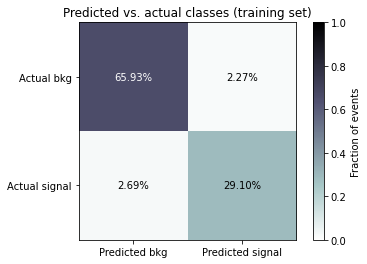

In [15]:
plt.imshow(confusionMatrix_Train, cmap='bone_r')
ax = plt.gca()
plt.colorbar(label='Fraction of events')
plt.clim(0,1)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted bkg', 'Predicted signal'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual bkg', 'Actual signal'))
plt.text(0, 1, "{:.2%}".format(confusionMatrix_Train[1, 0]), ha='center', va='center', color='k')
plt.text(0, 0, "{:.2%}".format(confusionMatrix_Train[0, 0]), ha='center', va='center', color='w')
plt.text(1, 0, "{:.2%}".format(confusionMatrix_Train[0, 1]), ha='center', va='center', color='k')
plt.text(1, 1, "{:.2%}".format(confusionMatrix_Train[1, 1]), ha='center', va='center', color='k')
plt.title("Predicted vs. actual classes (training set)")
plt.show()

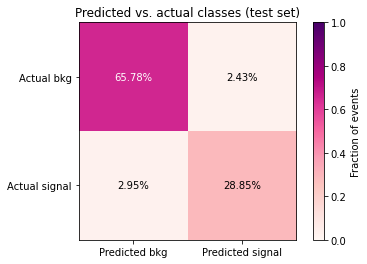

In [16]:
plt.imshow(confusionMatrix_Test, cmap='RdPu')
ax = plt.gca()
plt.colorbar(label='Fraction of events')
plt.clim(0,1)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted bkg', 'Predicted signal'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual bkg', 'Actual signal'))
plt.text(0, 1, "{:.2%}".format(confusionMatrix_Test[1, 0]), ha='center', va='center', color='k')
plt.text(0, 0, "{:.2%}".format(confusionMatrix_Test[0, 0]), ha='center', va='center', color='w')
plt.text(1, 0, "{:.2%}".format(confusionMatrix_Test[0, 1]), ha='center', va='center', color='k')
plt.text(1, 1, "{:.2%}".format(confusionMatrix_Test[1, 1]), ha='center', va='center', color='k')
plt.title("Predicted vs. actual classes (test set)")
plt.show()

## Classification reports

In [17]:
print("TRAIN")
print(metrics.classification_report(Y_train, Y_train_predicted))
print(f'The average precision score on training data is: {metrics.average_precision_score(Y_train, Y_train_proba_predicted):.4f}')
print("------------------------------------------------------")
print("TEST")
print(metrics.classification_report(Y_test, Y_test_predicted))
print(f'The average precision score on test data is: {metrics.average_precision_score(Y_test, Y_test_proba_predicted):.4f}')

TRAIN
              precision    recall  f1-score   support

           0       0.96      0.97      0.96    155849
           1       0.93      0.92      0.92     72649

    accuracy                           0.95    228498
   macro avg       0.94      0.94      0.94    228498
weighted avg       0.95      0.95      0.95    228498

The average precision score on training data is: 0.9755
------------------------------------------------------
TEST
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     17317
           1       0.92      0.91      0.91      8073

    accuracy                           0.95     25390
   macro avg       0.94      0.94      0.94     25390
weighted avg       0.95      0.95      0.95     25390

The average precision score on test data is: 0.9723


## ROC curve

In [18]:
falsePositiveRates_Train, truePositiveRates_Train, thresholds_Trrain = metrics.roc_curve(Y_train, Y_train_proba_predicted)
areaUnderCurve_Train = metrics.roc_auc_score(Y_train, Y_train_proba_predicted)

falsePositiveRates_Test, truePositiveRates_Test, thresholds_Test = metrics.roc_curve(Y_test, Y_test_proba_predicted)
areaUnderCurve_Test = metrics.roc_auc_score(Y_test, Y_test_proba_predicted)

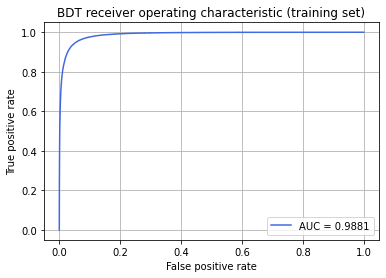

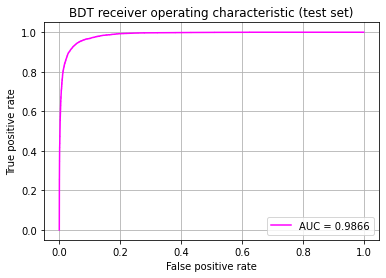

In [19]:
plt.plot(falsePositiveRates_Train, truePositiveRates_Train,
         label=f'AUC = {areaUnderCurve_Train:.4f}',
         color='royalblue')
plt.grid()
plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("BDT receiver operating characteristic (training set)")
plt.show()

plt.plot(falsePositiveRates_Test, truePositiveRates_Test, label=f'AUC = {areaUnderCurve_Test:.4f}', color='fuchsia')
plt.grid()
plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("BDT receiver operating characteristic (test set)")
plt.show()

## Precision-recall curve

In [20]:
precisions_Train, recalls_Train, PRC_Thresholds_Train = metrics.precision_recall_curve(Y_train, Y_train_proba_predicted)
precisions_Test, recalls_Test, PRC_Thresholds_Test = metrics.precision_recall_curve(Y_test, Y_test_proba_predicted)

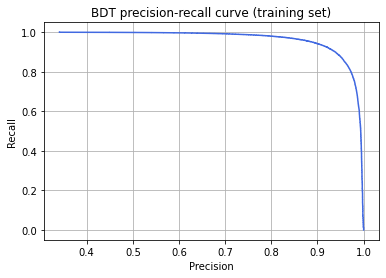

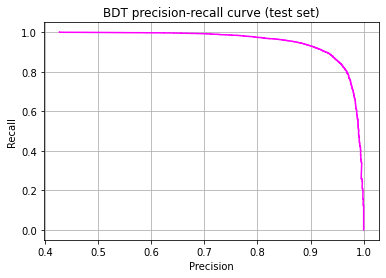

In [21]:
plt.plot(precisions_Train, recalls_Train, color='royalblue')
plt.grid()
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title("BDT precision-recall curve (training set)")
plt.show()

plt.plot(precisions_Test, recalls_Test, color='fuchsia')
plt.grid()
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title("BDT precision-recall curve (test set)")
plt.show()

## Response distribution

In [22]:
df_model_response_train = pd.DataFrame({'predicted' : Y_train_proba_predicted, 'class' : Y_train, 'dataset': 'train'})
df_model_response_test = pd.DataFrame({'predicted' : Y_test_proba_predicted, 'class' : Y_test, 'dataset': 'test'})
df_model_response = pd.concat([df_model_response_train, df_model_response_test], ignore_index=True)

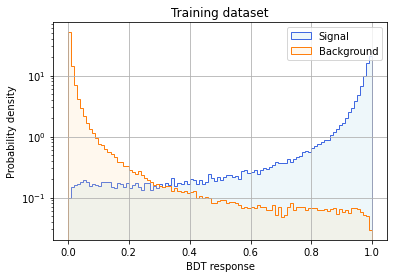

In [23]:
plt.hist(
    df_model_response[(df_model_response['dataset'] == 'train') & (df_model_response['class'] == 1)]['predicted'],
    label='Signal',
    bins=100,
    range=(0,1),
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    histtype= "stepfilled",
    density=True
)

plt.hist(
    df_model_response[(df_model_response['dataset'] == 'train') & (df_model_response['class'] == 0)]['predicted'],
    label='Background',
    bins=100,
    range=(0,1),
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    histtype= "stepfilled",
    density=True,
    edgecolor='tab:orange',
)

plt.yscale('log')
plt.legend()
plt.grid()
plt.title("Training dataset")
plt.ylabel("Probability density")
plt.xlabel("BDT response")
plt.show()

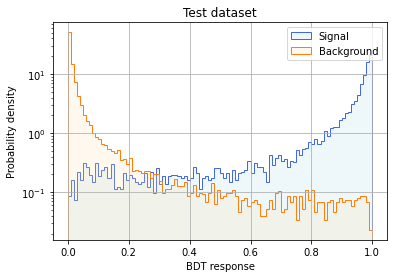

In [24]:
plt.hist(
    df_model_response[(df_model_response['dataset'] == 'test') & (df_model_response['class'] == 1)]['predicted'],
    label='Signal',
    bins=100,
    range=(0,1),
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    histtype= "stepfilled",
    density=True
)

plt.hist(
    df_model_response[(df_model_response['dataset'] == 'test') & (df_model_response['class'] == 0)]['predicted'],
    label='Background',
    bins=100,
    range=(0,1),
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    histtype= "stepfilled",
    density=True,
    edgecolor='tab:orange',
)

plt.yscale('log')
plt.legend()
plt.grid()
plt.title("Test dataset")
plt.ylabel("Probability density")
plt.xlabel("BDT response")
plt.show()

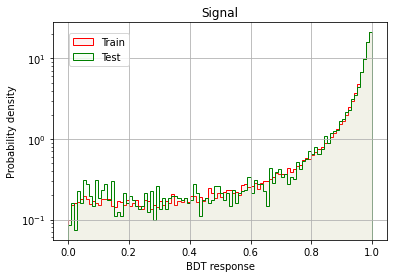

In [25]:
plt.hist(
    df_model_response[(df_model_response['dataset'] == 'train') & (df_model_response['class'] == 1)]['predicted'],
    label='Train',
    bins=100,
    range=(0,1),
    color=mcolors.to_rgba('lightcoral', alpha=0.1),
    edgecolor='red',
    histtype= "stepfilled",
    density=True
)

plt.hist(
    df_model_response[(df_model_response['dataset'] == 'test') & (df_model_response['class'] == 1)]['predicted'],
    label='Test',
    bins=100,
    range=(0,1),
    color=mcolors.to_rgba('palegreen', alpha=0.1),
    edgecolor='green',
    histtype= "stepfilled",
    density=True
)

plt.yscale('log')
plt.legend(loc=(0.05,0.8))
plt.grid()
plt.title("Signal")
plt.ylabel("Probability density")
plt.xlabel("BDT response")
plt.show()

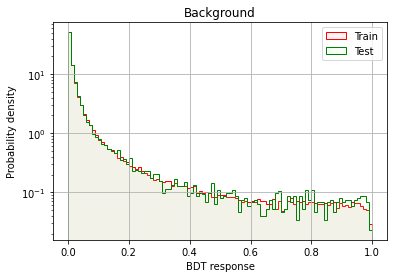

In [26]:
plt.hist(
    df_model_response[(df_model_response['dataset'] == 'train') & (df_model_response['class'] == 0)]['predicted'],
    label='Train',
    bins=100,
    range=(0,1),
    color=mcolors.to_rgba('lightcoral', alpha=0.1),
    edgecolor='red',
    histtype= "stepfilled",
    density=True
)

plt.hist(
    df_model_response[(df_model_response['dataset'] == 'test') & (df_model_response['class'] == 0)]['predicted'],
    label='Test',
    bins=100,
    range=(0,1),
    color=mcolors.to_rgba('palegreen', alpha=0.1),
    edgecolor='green',
    histtype= "stepfilled",
    density=True
)

plt.yscale('log')
plt.grid()
plt.legend()
plt.title("Background")
plt.ylabel("Probability density")
plt.xlabel("BDT response")
plt.show()

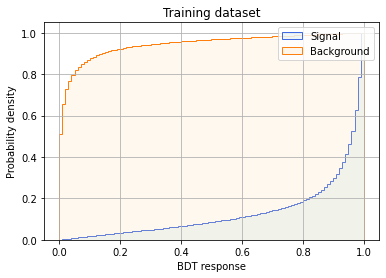

In [27]:
plt.hist(
    df_model_response[(df_model_response['dataset'] == 'train') & (df_model_response['class'] == 1)]['predicted'],
    label='Signal',
    bins=100,
    range=(0,1),
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    histtype= "stepfilled",
    density=True,
    cumulative=True
)

plt.hist(
    df_model_response[(df_model_response['dataset'] == 'train') & (df_model_response['class'] == 0)]['predicted'],
    label='Background',
    bins=100,
    range=(0,1),
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    histtype= "stepfilled",
    density=True,
    edgecolor='tab:orange',
    cumulative=True
)

plt.legend()
plt.grid()
plt.title("Training dataset")
plt.ylabel("Probability density")
plt.xlabel("BDT response")
plt.show()

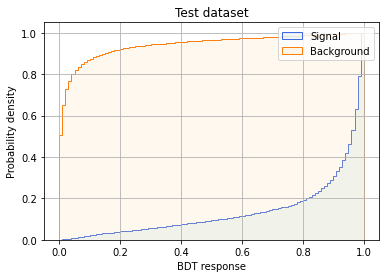

In [28]:
plt.hist(
    df_model_response[(df_model_response['dataset'] == 'test') & (df_model_response['class'] == 1)]['predicted'],
    label='Signal',
    bins=100,
    range=(0,1),
    fc=mcolors.to_rgba('lightblue', alpha=0.2),
    edgecolor='royalblue',
    histtype= "stepfilled",
    density=True,
    cumulative=True
)

plt.hist(
    df_model_response[(df_model_response['dataset'] == 'test') & (df_model_response['class'] == 0)]['predicted'],
    label='Background',
    bins=100,
    range=(0,1),
    fc=mcolors.to_rgba('navajowhite', alpha=0.2),
    histtype= "stepfilled",
    density=True,
    edgecolor='tab:orange',
    cumulative=True
)

plt.legend()
plt.grid()
plt.title("Test dataset")
plt.ylabel("Probability density")
plt.xlabel("BDT response")
plt.show()

## Kolmogorov-Smirnov test
### Signal (train vs. test)

In [29]:
stats.kstest(
    df_model_response[(df_model_response['dataset'] == 'train') & (df_model_response['class'] == 1)]['predicted'],
    df_model_response[(df_model_response['dataset'] == 'test') & (df_model_response['class'] == 1)]['predicted']
)

KstestResult(statistic=0.011278025811275905, pvalue=0.3114324509588666)

### Background (train vs. test)

In [30]:
stats.kstest(
    df_model_response[(df_model_response['dataset'] == 'train') & (df_model_response['class'] == 0)]['predicted'],
    df_model_response[(df_model_response['dataset'] == 'test') & (df_model_response['class'] == 0)]['predicted']
)

KstestResult(statistic=0.006860020848838744, pvalue=0.4536430043120274)

## Feature importances

In [31]:
## Input is the full output of sklearn.inspection.permutation_importance
## for training and testing data. Output is a dataframe containing
## importance mean and error for each feature. Mean is given by sklearn,
## error is computed as standard deviation divided by the square root of
## the number of times importanes were computed (i.e. n_repeats).
def importancesToDataFrame(trainImportancesOutput, testImportancesOutput):
    dataList=[]
    dataList.append(trainImportancesOutput['importances_mean'])
    dataList.append(trainImportancesOutput['importances_std']/np.sqrt(trainImportancesOutput['importances'].shape[1]))
    dataList.append(testImportancesOutput['importances_mean'])
    dataList.append(testImportancesOutput['importances_std']/np.sqrt(testImportancesOutput['importances'].shape[1]))
    
    indexList = ['train_mean', 'train_error', 'test_mean', 'test_error']
    return pd.DataFrame(dataList, index=indexList, columns=features)

In [32]:
if compute_importances:
    importanceTick = time.perf_counter()
    train_importances = inspection.permutation_importance(
        BDT,
        X_train,
        Y_train,
        scoring='average_precision',
        n_repeats=10,
        random_state=2021,
        n_jobs=10
    )

    test_importances = inspection.permutation_importance(
        BDT,
        X_test,
        Y_test,
        scoring='average_precision',
        n_repeats=10,
        random_state=2021,
        n_jobs=10
    )
    importanceTock = time.perf_counter()
    print(f"Importances computed in {(importanceTock - importanceTick)/60:0.4f} minutes.")
    
    df_importance = importancesToDataFrame(train_importances, test_importances)
    df_importance.to_csv(savedStateDirectory + '/' + fileNamePattern + '.csv')
else:
    df_importance = pd.read_csv(savedStateDirectory + '/' + fileNamePattern + '.csv', index_col=0)

Importances computed in 0.4333 minutes.


In [33]:
featureLabels = {
    'p_PT': '$p_T(p)$',
    'DTF_FixJPsi_p_PT': '$p_T^{DTF}(p)$',
    'DTF_FixJPsiLambda_p_PT': '$p_T^{DTF}(p)$ ($\Lambda$ m.c.)',
    'p_PZ': '$p_z(p)$',
    'DTF_FixJPsi_p_PZ': '$p_z^{DTF}(p)$',
    'DTF_FixJPsiLambda_p_PZ': '$p_z^{DTF}(p)$ ($\Lambda$ m.c.)',
    'pim_PT': '$p_T(\pi)$',
    'DTF_FixJPsi_pim_PT': '$p_T^{DTF}(\pi)$',
    'DTF_FixJPsiLambda_pim_PT': '$p_T^{DTF}(\pi)$ ($\Lambda$ m.c.)',
    'pim_PZ': '$p_z(\pi)$',
    'DTF_FixJPsi_pim_PZ': '$p_z^{DTF}(\pi)$',
    'DTF_FixJPsiLambda_pim_PZ': '$p_Z^{DTF}(\pi)$ ($\Lambda$ m.c.)',
    'Jpsi_PT': '$p_T(J/\psi)$',
    'Jpsi_PZ': '$p_z(J/\psi)$',
    'L_ENDVERTEX_X': '$x_{vtx}^\Lambda$',
    'L_ENDVERTEX_Y': '$y_{vtx}^\Lambda$',
    'L_ENDVERTEX_Z': '$z_{vtx}^\Lambda$',
    'L_BPVDIRA': '$\Lambda$ DIRA',
    'Lb_BPVDIRA': '$\Lambda_b$ DIRA',
    'L_VFASPF_CHI2_VDOF': '$\chi^2_{vtx}(\Lambda)$',
    'Lb_VFASPF_CHI2_VDOF': '$\chi^2_{vtx}(\Lambda_b)$',
    'L_BPVIPCHI2': '$\Lambda$ IPCHI2',
    'Lb_BPVIPCHI2': '$\Lambda_b$ IPCHI2',
    'L_BPVVDCHI2': '$\Lambda$ VDCHI2',
    'Lb_BPVVDCHI2': '$\Lambda_b$ VDCHI2',
    'DTF_FixJPsi_status': 'DTF status',
    'DTF_FixJPsiLambda_status': 'DTF status ($\Lambda$ m.c.)'
}

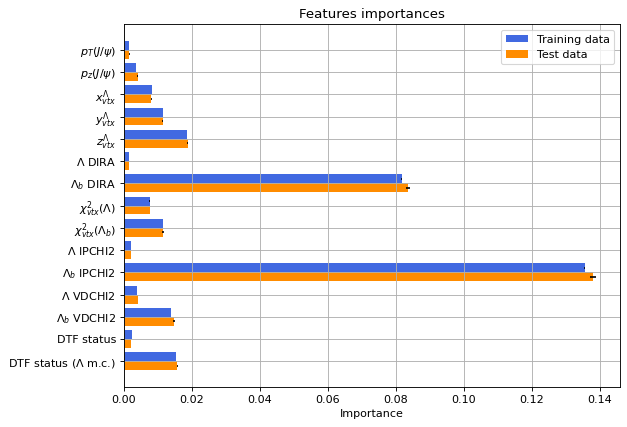

In [34]:
## Index: where we plot the bars
## bar_width: smaller so we can fit both training and test data
index = np.arange(len(features))
bar_width=0.4

plt.figure(figsize=(8, 6), dpi=80)

plt.barh(
    index,
    df_importance.loc['train_mean'],
    bar_width,
    xerr=df_importance.loc['train_error'],
    label='Training data',
    color='royalblue'
)

## Plot test data shifted by bar_width so it appears above test data
plt.barh(
    index+bar_width,
    df_importance.loc['test_mean'],
    bar_width,
    xerr=df_importance.loc['test_error'],
    label='Test data',
    color='darkorange'
)

plt.legend()
plt.title("Features importances")
plt.xlabel("Importance")

## Manually set labels position and text, since we used the index
ax = plt.gca()
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels([featureLabels[feature] for feature in features])

plt.grid()
plt.gca().invert_yaxis()
plt.show()

# Output for BDT performance analyzer

In [35]:
train_TN, train_FP, train_FN, train_TP = confusionMatrix_Train.flatten()
test_TN, test_FP, test_FN, test_TP = confusionMatrix_Test.flatten()

stat_sig, p_sig = stats.kstest(
    df_model_response[(df_model_response['dataset'] == 'train') & (df_model_response['class'] == 1)]['predicted'],
    df_model_response[(df_model_response['dataset'] == 'test') & (df_model_response['class'] == 1)]['predicted']
)

stat_bkg, p_bkg = stats.kstest(
    df_model_response[(df_model_response['dataset'] == 'train') & (df_model_response['class'] == 0)]['predicted'],
    df_model_response[(df_model_response['dataset'] == 'test') & (df_model_response['class'] == 0)]['predicted']
)

In [36]:
performanceList = [
    [train_TN, train_FP, train_FN, train_TP, areaUnderCurve_Train, metrics.average_precision_score(Y_train, Y_train_proba_predicted)],
    [test_TN, test_FP, test_FN, test_TP, areaUnderCurve_Test, metrics.average_precision_score(Y_test, Y_test_proba_predicted)],
    p_sig,
    p_bkg
]

This is already in the preferred format for the analyzer.

In [37]:
print(performanceList)

[[0.6593318103440731, 0.022726675944647216, 0.026936778440073875, 0.29100473527120585, 0.9880650720881631, 0.9755415872571885], [0.6577786530129972, 0.024261520283576213, 0.02949980307207562, 0.2884600236313509, 0.9866017016391992, 0.9723033154590903], 0.3114324509588666, 0.4536430043120274]
